In [1]:
# Bibliothèques Générales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modèles Statistiques Traditionnels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

# Apprentissage Automatique
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten

# XGBoost
import xgboost as xgb

# Transformers (Time Series)
# from transformers import TimeSeriesTransformer

from darts.models import TransformerModel

# Ensemble Learning
from sklearn.ensemble import VotingRegressor, StackingRegressor

import yfinance as yf

# Analyse Technique
import talib

In [2]:
from datetime import date

In [3]:
# On commence par récupérer les données du CAC40 sur yahoo finance

aujourdhui = date.today()
aujourdhui = aujourdhui.strftime('%Y-%m-%d')
aujourdhui

# le CAC40 a un ticker qui correspond aux standards de la convention de dénomination des indices 
# boursiers de Reuters, sont ticker est ^FCHI

# start="2020-01-01", end="2023-12-31"
# start='2020-01-01', end=aujourdhui
ticker = '^FCHI' 
cac40 = yf.download(ticker, start="2020-01-01", end="2023-12-31")
cac40

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,6016.609863,6062.919922,6011.209961,6041.500000,6041.500000,63958300
2020-01-03,6007.959961,6044.160156,5994.589844,6044.160156,6044.160156,60488000
2020-01-06,6001.209961,6017.970215,5955.250000,6013.589844,6013.589844,69063700
2020-01-07,6033.220215,6065.740234,6000.000000,6012.350098,6012.350098,69593800
2020-01-08,5986.810059,6031.000000,5972.770020,6031.000000,6031.000000,71431600
...,...,...,...,...,...,...
2023-12-21,7557.160156,7574.709961,7537.810059,7571.399902,7571.399902,36202800
2023-12-22,7560.970215,7589.000000,7557.580078,7568.819824,7568.819824,31755700
2023-12-27,7580.970215,7603.270020,7560.540039,7571.819824,7571.819824,31599200


In [4]:
ticker = "^FCHI"

# Obtenir l'objet Ticker
cac = yf.Ticker(ticker)

# Vérifier les dividendes
dividends = cac.dividends
print("Dividendes :")
print(dividends)

# Vérifier les splits d'actions
splits = cac.splits
print("Splits d'Actions :")
print(splits)


# Afficher les premières lignes des données
print(cac40[['Close', 'Adj Close']].head())

Dividendes :
Series([], Name: Dividends, dtype: float64)
Splits d'Actions :
Series([], Name: Stock Splits, dtype: float64)
                  Close    Adj Close
Date                                
2020-01-02  6041.500000  6041.500000
2020-01-03  6044.160156  6044.160156
2020-01-06  6013.589844  6013.589844
2020-01-07  6012.350098  6012.350098
2020-01-08  6031.000000  6031.000000


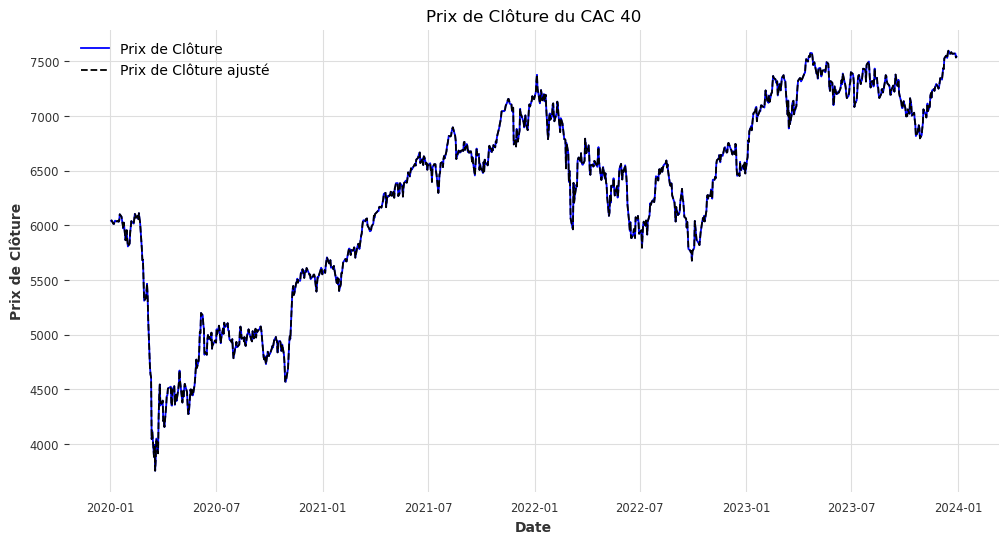

In [5]:
# Tracer les prix de clôture
plt.figure(figsize=(12, 6))
plt.plot(cac40['Close'], label="Prix de Clôture", color='blue')
plt.plot(cac40['Adj Close'], label='Prix de Clôture ajusté', color='black', linestyle='--')
plt.title("Prix de Clôture du CAC 40")
plt.xlabel("Date")
plt.ylabel("Prix de Clôture")
plt.legend()
plt.grid(True)

Petite vérification pour voir si TOTAL (entreprise du CAC40) a versé des dividendes ou a réalisé un SPLIT sur la période, ce qui devrait donner une différence entre le cours de clôture et le cours de clôture ajusté

[*********************100%%**********************]  1 of 1 completed

Dividendes pour TTE.PA:
Date
2000-06-14 00:00:00+02:00    0.5875
2001-05-29 00:00:00+02:00    0.8250
2002-05-17 00:00:00+02:00    0.9500
2003-05-16 00:00:00+02:00    1.0250
2004-05-19 00:00:00+02:00    0.1575
                              ...  
2023-06-21 00:00:00+02:00    0.7400
2023-09-20 00:00:00+02:00    0.7400
2024-01-02 00:00:00+01:00    0.7400
2024-03-20 00:00:00+01:00    0.7400
2024-06-19 00:00:00+02:00    0.7900
Name: Dividends, Length: 74, dtype: float64
Splits d'Actions pour TTE.PA:
Date
2006-05-18 00:00:00+02:00    4.0
Name: Stock Splits, dtype: float64
                Close  Adj Close
Date                            
2020-01-02  49.814999  36.635113
2020-01-03  50.380001  37.050625
2020-01-06  50.439999  37.587162
2020-01-07  50.110001  37.341248
2020-01-08  50.240002  37.438114


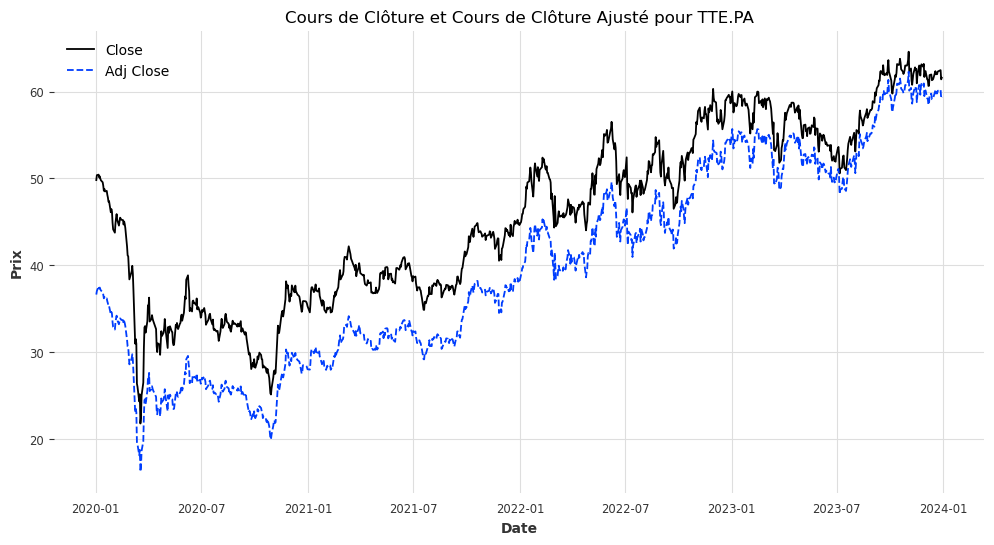

In [6]:
total_ticker = "TTE.PA"
total = yf.Ticker(total_ticker)

# Vérifier les dividendes pour TotalEnergies
total_dividends = total.dividends
print(f"Dividendes pour {total_ticker}:")
print(total_dividends)

# Vérifier les splits d'actions pour TotalEnergies
total_splits = total.splits
print(f"Splits d'Actions pour {total_ticker}:")
print(total_splits)

# Télécharger les données historiques pour comparer Close et Adj Close pour TotalEnergies
total_data = yf.download(total_ticker, start="2020-01-01", end="2023-12-31")

# Afficher les premières lignes des données
print(total_data[['Close', 'Adj Close']].head())

# Tracer les cours de clôture et les cours de clôture ajustés pour TotalEnergies
plt.figure(figsize=(12, 6))
plt.plot(total_data['Close'], label="Close")
plt.plot(total_data['Adj Close'], label="Adj Close", linestyle='--')
plt.title(f"Cours de Clôture et Cours de Clôture Ajusté pour {total_ticker}")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)

S&P500 vérification des ajustements de cours de clôture

[*********************100%%**********************]  1 of 1 completed


                  Close    Adj Close
Date                                
2020-01-02  3257.850098  3257.850098
2020-01-03  3234.850098  3234.850098
2020-01-06  3246.280029  3246.280029
2020-01-07  3237.179932  3237.179932
2020-01-08  3253.050049  3253.050049


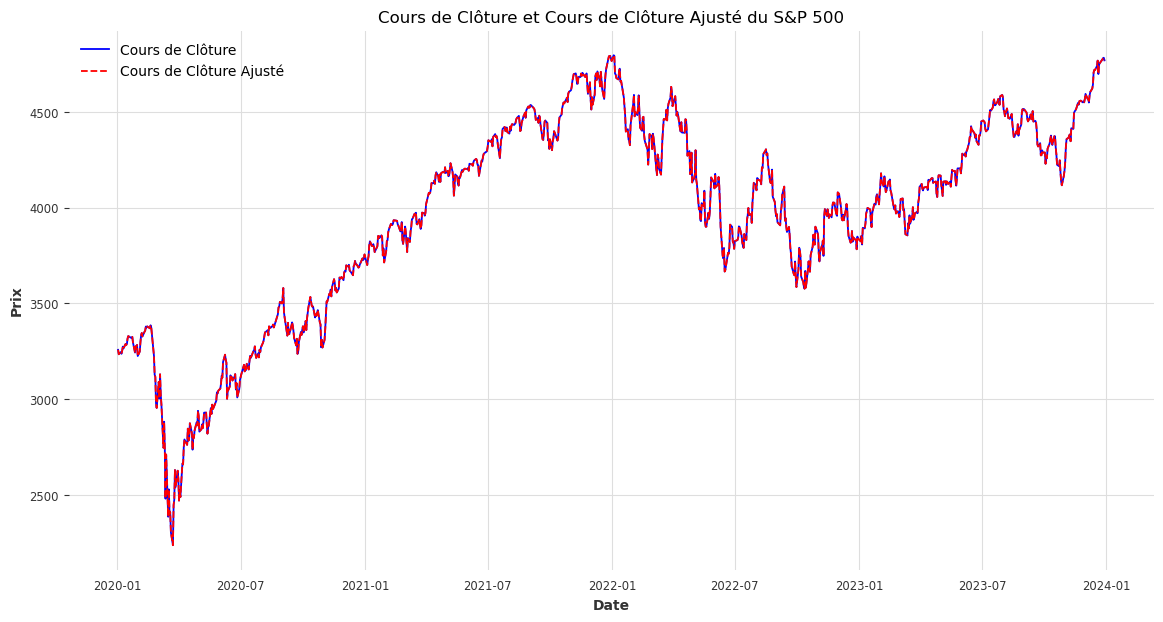

In [7]:
import yfinance as yf
import matplotlib.pyplot as plt

# Définir le ticker pour le S&P 500
ticker = "^GSPC"  # Ticker de l'indice S&P 500 sur Yahoo Finance

# Télécharger les données historiques pour le S&P 500
sp500_data = yf.download(ticker, start="2020-01-01", end="2023-12-31")

# Afficher les premières lignes des données
print(sp500_data[['Close', 'Adj Close']].head())

# Tracer les cours de clôture et les cours de clôture ajustés
plt.figure(figsize=(14, 7))

# Tracer les cours de clôture
plt.plot(sp500_data['Close'], label="Cours de Clôture", color='blue')

# Tracer les cours de clôture ajustés
plt.plot(sp500_data['Adj Close'], label="Cours de Clôture Ajusté", linestyle='--', color='red')

# Ajouter des titres et des labels
plt.title("Cours de Clôture et Cours de Clôture Ajusté du S&P 500")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)

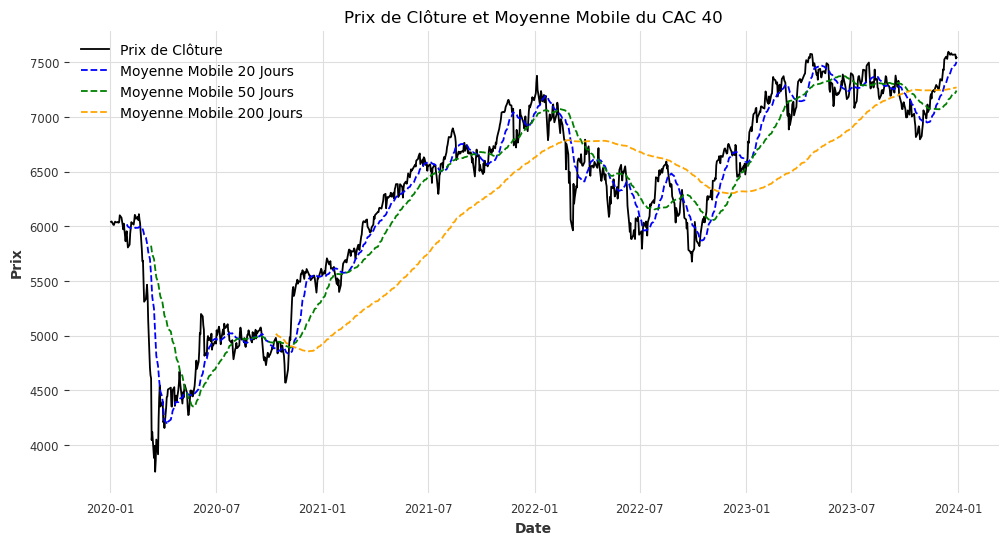

In [8]:
# Calculer la moyenne mobile simple sur 50 jours
# par défaut window prend le nombre d'observation, ici on demande 50 et comme nos cours de bourse
# sont journaliers ont moyenne sur les 50 derniers jours de bourse ouvrés
cac40['Moyenne_mobile_20'] = cac40['Adj Close'].rolling(window=20).mean()
cac40['Moyenne_mobile_50'] = cac40['Adj Close'].rolling(window=50).mean()
cac40['Moyenne_mobile_200'] = cac40['Adj Close'].rolling(window=200).mean()

# Calculer les moyennes mobiles exponentielles (EMA)
cac40['Exp_moyenne_mobile_12'] = cac40['Adj Close'].ewm(span=12, adjust=False).mean()
cac40['Exp_moyenne_mobile_26'] = cac40['Adj Close'].ewm(span=26, adjust=False).mean()



# Tracer les prix de clôture et la moyenne mobile
plt.figure(figsize=(12, 6))
plt.plot(cac40['Adj Close'], label="Prix de Clôture")
plt.plot(cac40['Moyenne_mobile_20'], label="Moyenne Mobile 20 Jours", linestyle='--', color='blue')
plt.plot(cac40['Moyenne_mobile_50'], label="Moyenne Mobile 50 Jours", linestyle='--', color='green')
plt.plot(cac40['Moyenne_mobile_200'], label="Moyenne Mobile 200 Jours", linestyle='--', color='orange')

# plt.plot(cac40['Exp_moyenne_mobile_12'], label="Moyenne Mobile Expo 12 Jours", color='gold')
# plt.plot(cac40['Exp_moyenne_mobile_26'], label="Moyenne Mobile Expo 26 Jours", color='darkorange')


plt.title("Prix de Clôture et Moyenne Mobile du CAC 40")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)

# 1. Concept de l'EMA

La Moyenne Mobile Exponentielle (EMA) est une version plus réactive de la moyenne mobile. Contrairement à la SMA, qui accorde le même poids à chaque prix dans la période, l'EMA donne plus de poids aux prix récents. Cela la rend plus sensible aux changements récents du marché.

# 2. Calcul de l'EMA

Le calcul de l'EMA implique deux étapes principales :

## Calcul du facteur de lissage

Ce facteur est déterminé par la période choisie. Il est calculé comme suit :

$$
\text{Facteur de lissage} = \frac{2}{\text{Période} + 1}
$$

Pour une EMA de 12 jours, le facteur de lissage est

$$
\frac{2}{12 + 1} \approx 0.1538
$$

## Application du facteur de lissage

L'EMA est calculée en utilisant la formule récursive :

$$
\text{EMA}_{\text{aujourd'hui}} = (\text{Prix}_{\text{aujourd'hui}} \times \text{Facteur de lissage}) + (\text{EMA}_{\text{hier}} \times (1 - \text{Facteur de lissage}))
$$

L'EMA est donc une combinaison du prix actuel et de l'EMA précédente, pondérée par le facteur de lissage.

# 3. Périodes Courtes de l'EMA

- **EMA 12 jours** : Utilisée pour capturer les tendances à court terme. Elle est plus réactive aux changements de prix récents.
- **EMA 26 jours** : Utilisée pour capturer les tendances intermédiaires. Elle est moins réactive que l'EMA de 12 jours, mais plus réactive que les moyennes mobiles plus longues.

# 4. Utilisation des EMA

Les EMA sont souvent utilisées dans les stratégies de trading pour identifier les tendances et les signaux de trading :

- **Croisement des EMA** : Lorsque l'EMA de courte période (comme 12 jours) croise au-dessus de l'EMA de longue période (comme 26 jours), cela peut être un signal d'achat. Inversement, lorsque l'EMA de courte période croise en dessous de l'EMA de longue période, cela peut être un signal de vente.

- **MACD (Moving Average Convergence Divergence)** : L'EMA est également utilisée dans le calcul du MACD, un indicateur populaire pour détecter les changements de tendance en utilisant la différence entre deux EMA (généralement 12 jours et 26 jours) et une EMA de signal (souvent 9 jours).


#### Pour le calcul de la première valeur de l'EMA on fait une simple moyenne mobile, puis pour les valeurs suivantes on applique le principe expliqué ci-dessus, voici un exemple pour que vous compreniez

# Exemple
Supposons que nous voulons calculer une EMA de 5 jours pour une série de prix donnés. Voici les étapes concrètes :

## Déterminer le facteur de lissage :

$$
\alpha = \frac{2}{5 + 1} = \frac{2}{6} = 0.3333
$$

## Calculer l'EMA initiale (SMA des 5 premiers jours) :

Si les prix des 5 premiers jours sont 10, 11, 12, 13, et 14 :

$$
\text{SMA} = \frac{10 + 11 + 12 + 13 + 14}{5} = \frac{60}{5} = 12
$$

Donc,

$$
\text{EMA}_1 = 12
$$

## Calculer l'EMA pour les jours suivants :

Supposons que le prix du 6ème jour est 15 :

$$
\text{EMA}_6 = \alpha \times \text{Prix}_6 + (1 - \alpha) \times \text{EMA}_5
$$

$$
\text{EMA}_6 = 0.3333 \times 15 + (1 - 0.3333) \times 12
$$

$$
\text{EMA}_6 = 0.3333 \times 15 + 0.6667 \times 12
$$

$$
\text{EMA}_6 = 5 + 8 = 13
$$

Ainsi, l'EMA pour le 6ème jour est 13.

En répétant ce calcul pour chaque jour suivant, vous pouvez obtenir les valeurs de l'EMA pour l'ensemble de la série de prix.


[*********************100%%**********************]  1 of 1 completed


l'objet crossing :                     Open         High          Low        Close    Adj Close  \
Date                                                                          
2024-04-05  8050.250000  8062.009766  8019.290039  8061.310059  8061.310059   
2024-05-09  8123.919922  8191.919922  8114.879883  8187.649902  8187.649902   
2024-05-29  8033.560059  8040.029785  7926.419922  7935.029785  7935.029785   

              Volume  Exp_moyenne_mobile_12  Exp_moyenne_mobile_26  
Date                                                                
2024-04-05  65166400            8124.826577            8127.904688  
2024-05-09  39071500            8061.488533            8060.542769  
2024-05-29  62601300            8092.348856            8100.271551  
Le type de l'objet crossing :  <class 'pandas.core.frame.DataFrame'>


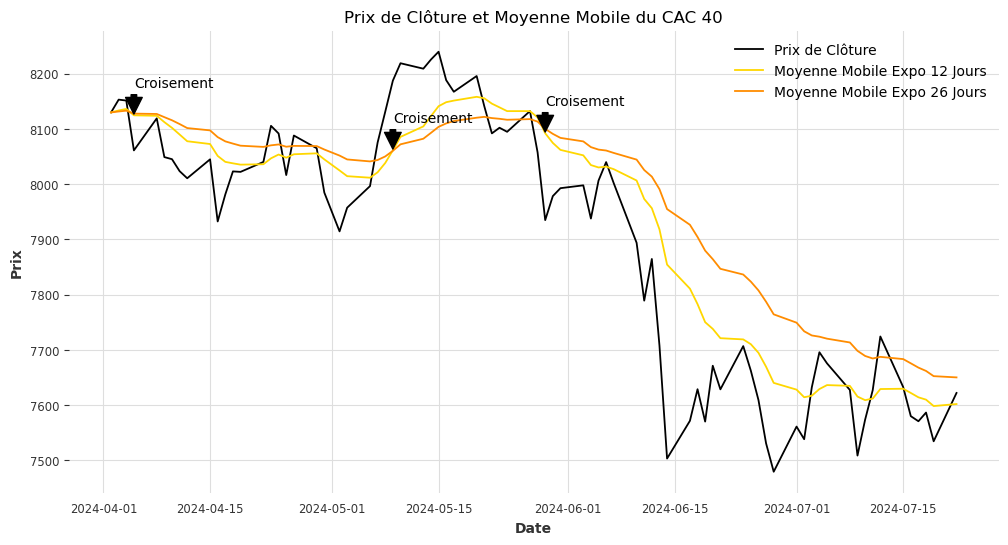

In [9]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date

# On commence par récupérer les données du CAC40 sur yahoo finance
aujourdhui = date.today()
aujourdhui = aujourdhui.strftime('%Y-%m-%d')

# le CAC40 a un ticker qui correspond aux standards de la convention de dénomination des indices boursiers de Reuters, son ticker est ^FCHI
ticker = '^FCHI'
cac40 = yf.download(ticker, start='2024-04-01', end=aujourdhui)

# Calculer les moyennes mobiles exponentielles (EMA)
cac40['Exp_moyenne_mobile_12'] = cac40['Adj Close'].ewm(span=12, adjust=False).mean()
cac40['Exp_moyenne_mobile_26'] = cac40['Adj Close'].ewm(span=26, adjust=False).mean()


# Identifier les points de croisement : On utilise une condition pour identifier les jours 
# où les EMA se croisent, on utlise .shift(1) pour comparer avec la valeur précédente
crossings = cac40[(cac40['Exp_moyenne_mobile_12'] > cac40['Exp_moyenne_mobile_26']) & 
                  (cac40['Exp_moyenne_mobile_12'].shift(1) < cac40['Exp_moyenne_mobile_26'].shift(1)) | 
                  (cac40['Exp_moyenne_mobile_12'] < cac40['Exp_moyenne_mobile_26']) & 
                  (cac40['Exp_moyenne_mobile_12'].shift(1) > cac40['Exp_moyenne_mobile_26'].shift(1))]


print("l'objet crossing : ", crossings)
print("Le type de l'objet crossing : ", type(crossings))
# C'est un dataFrame

# Tracer les prix de clôture et la moyenne mobile
plt.figure(figsize=(12, 6))
plt.plot(cac40['Adj Close'], label="Prix de Clôture")
plt.plot(cac40['Exp_moyenne_mobile_12'], label="Moyenne Mobile Expo 12 Jours", color='gold')
plt.plot(cac40['Exp_moyenne_mobile_26'], label="Moyenne Mobile Expo 26 Jours", color='darkorange')

# Ajouter des annotations aux points de croisement
for index, row in crossings.iterrows():
    plt.annotate('Croisement', xy=(index, row['Exp_moyenne_mobile_12']), 
                 xytext=(index, row['Exp_moyenne_mobile_12']+50),
                 arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Prix de Clôture et Moyenne Mobile du CAC 40")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)

#### Explications sur la manière dont le facteur a été choisi

# Analyse Technique

L'analyse technique est basée sur l'idée que les prix des actifs financiers suivent des tendances et que ces tendances peuvent être identifiées et exploitées pour prendre des décisions de trading. Contrairement à l'analyse fondamentale, qui se concentre sur les états financiers, les perspectives de croissance et d'autres facteurs économiques, l'analyse technique utilise des graphiques et divers indicateurs pour prévoir les mouvements futurs des prix.

# Moyennes Mobiles

Les moyennes mobiles sont l'un des outils les plus simples et les plus utilisés en analyse technique. Elles servent à lisser les fluctuations de prix sur une certaine période, ce qui permet d'identifier plus facilement les tendances sous-jacentes.

- **Moyenne mobile simple (SMA)** : Calculée en faisant la moyenne des prix de clôture sur une période donnée.
- **Moyenne mobile exponentielle (EMA)** : Donne plus de poids aux prix récents, ce qui la rend plus réactive aux nouveaux mouvements de prix.

# Croisement de Moyennes Mobiles

Le croisement de moyennes mobiles est une stratégie couramment utilisée pour générer des signaux d'achat et de vente :

- **Croisement Haussier (Golden Cross)** : Se produit lorsque la moyenne mobile à court terme (par exemple, 50 jours) dépasse la moyenne mobile à long terme (par exemple, 200 jours). Cela est considéré comme un signal d'achat car il indique que les prix récents augmentent plus rapidement que les prix historiques, suggérant une tendance haussière.
- **Croisement Baissier (Death Cross)** : Se produit lorsque la moyenne mobile à court terme descend en dessous de la moyenne mobile à long terme. Cela est considéré comme un signal de vente car il indique que les prix récents diminuent plus rapidement que les prix historiques, suggérant une tendance baissière.

# Raisonnement Derrière le Croisement de Moyennes Mobiles

- **Confirmation de Tendance** : Les croisements de moyennes mobiles aident à confirmer le début d'une nouvelle tendance. Par exemple, un croisement haussier suggère qu'une nouvelle tendance haussière pourrait commencer.
- **Filtrage du Bruit** : En utilisant des moyennes mobiles, les traders peuvent filtrer les fluctuations de prix mineures (ou "bruit") et se concentrer sur les mouvements de prix plus significatifs.
- **Signal de Momentum** : Un croisement haussier indique un regain de momentum haussier, tandis qu'un croisement baissier indique un regain de momentum baissier.


[*********************100%%**********************]  1 of 1 completed
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


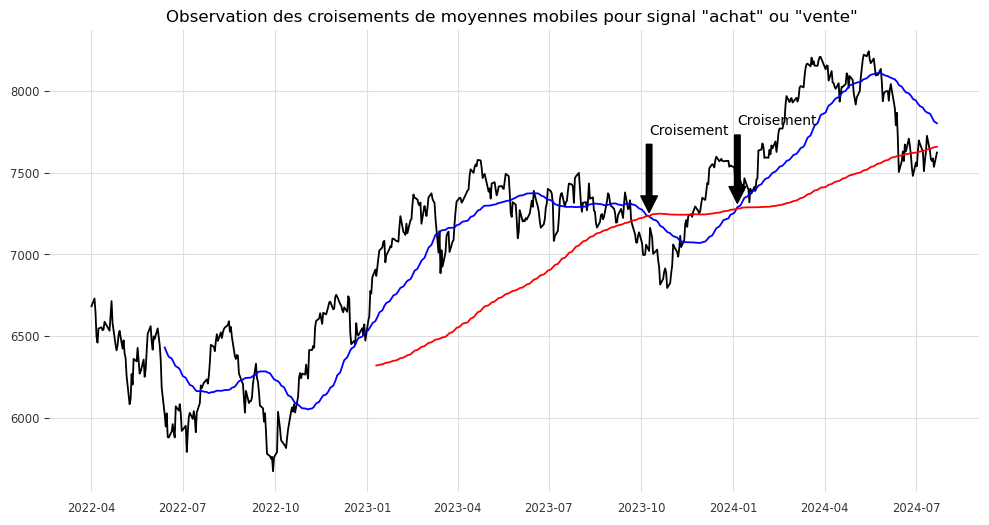

In [10]:
# Pour éviter de polluer le graphique avec des textes de mise en garde on importe warnings
# et on demande à ignorer les warnings
import warnings
warnings.filterwarnings("ignore")

# Utilisons le concept de base de croisement entre la moyenne mobile 50 et la moyenne mobile 200

# On commence par récupérer les données du CAC40 sur yahoo finance sur une période plus longue
# que précédemment car on va utiliser des moyennes mobiles qui prennent en compte 200 jours et 50 jours
aujourdhui = date.today()
aujourdhui = aujourdhui.strftime('%Y-%m-%d')

# le CAC40 a un ticker qui correspond aux standards de la convention de dénomination des indices boursiers de Reuters, son ticker est ^FCHI
ticker = '^FCHI'
cac40 = yf.download(ticker, start='2022-04-01', end=aujourdhui)

plt.figure(figsize=(12, 6))

cac40['Moyenne_mobile_50'] = cac40['Adj Close'].rolling(window=50).mean()
cac40['Moyenne_mobile_200'] = cac40['Adj Close'].rolling(window=200).mean()


# Identifier les croisements
crossings = cac40[(cac40['Moyenne_mobile_50'] > cac40['Moyenne_mobile_200']) & 
                  (cac40['Moyenne_mobile_50'].shift(1) <= cac40['Moyenne_mobile_200'].shift(1)) |
                  (cac40['Moyenne_mobile_50'] < cac40['Moyenne_mobile_200']) & 
                  (cac40['Moyenne_mobile_50'].shift(1) >= cac40['Moyenne_mobile_200'].shift(1))]




# Calcul des signaux d'achat (1) et de vente (-1)
cac40['Signal'] = 0
cac40['Signal'][200:] = np.where(cac40['Moyenne_mobile_50'][200:] > cac40['Moyenne_mobile_200'][200:], 1, -1)

# Identifier les changements dans les signaux pour déterminer les positions d'achat et de vente
cac40['Position'] = cac40['Signal'].diff()

# Extraire les dates et les types de signaux pour annotation
signal_achat = cac40[cac40['Position'] == 2]  # Position de 2 signifie un signal d'achat (1 - (-1))
signal_vente = cac40[cac40['Position'] == -2]  # Position de -2 signifie un signal de vente (-1 -1)


# Ajouter des annotations aux points de croisement
for index, row in crossings.iterrows():
    plt.annotate('Croisement', xy=(index, row['Moyenne_mobile_50']), 
                 xytext=(index, row['Moyenne_mobile_50']+500),
                 arrowprops=dict(facecolor='black', shrink=0.05))

plt.plot(cac40['Adj Close'])
plt.plot(cac40['Moyenne_mobile_50'], color='blue')
plt.plot(cac40['Moyenne_mobile_200'], color='red')
plt.title('Observation des croisements de moyennes mobiles pour signal "achat" ou "vente" ')
plt.legend()

### Le graphique est très clair mais plus précisément quels jours on aurait dû acheter ou vendre ? 

In [11]:
jour_de_vente = signal_vente.index.strftime('%Y-%m-%d')
jour_de_vente_list = jour_de_vente.tolist()
jour_de_vente_list = ''.join(jour_de_vente_list)
print('Il fallait vendre le : ', jour_de_vente_list)

Il fallait vendre le :  2023-10-09


In [12]:
jour_achat = signal_achat.index.strftime('%Y-%m-%d')
jour_achat_list = jour_achat.tolist()
jour_achat_list = ''.join(jour_achat_list)
print('Il fallait acheter le : ', jour_achat_list)

Il fallait acheter le :  2024-01-05


### Prédiction à l'aide des séries temporelles 

[*********************100%%**********************]  1 of 1 completed

Valeurs manquantes avant nettoyage: 0
Valeurs manquantes après nettoyage: 0


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  512
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -2945.473
Date:                Tue, 23 Jul 2024   AIC                           5898.945
Time:                        08:55:59   BIC                           5915.891
Sample:                             0   HQIC                          5905.589
                                - 512                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0321      0.036     -0.887      0.375      -0.103       0.039
ar.L2         -0.0407      0.038     -1.063      0.288      -0.116       0.034
ar.L3         -0.0305      0.028     -1.095      0.2

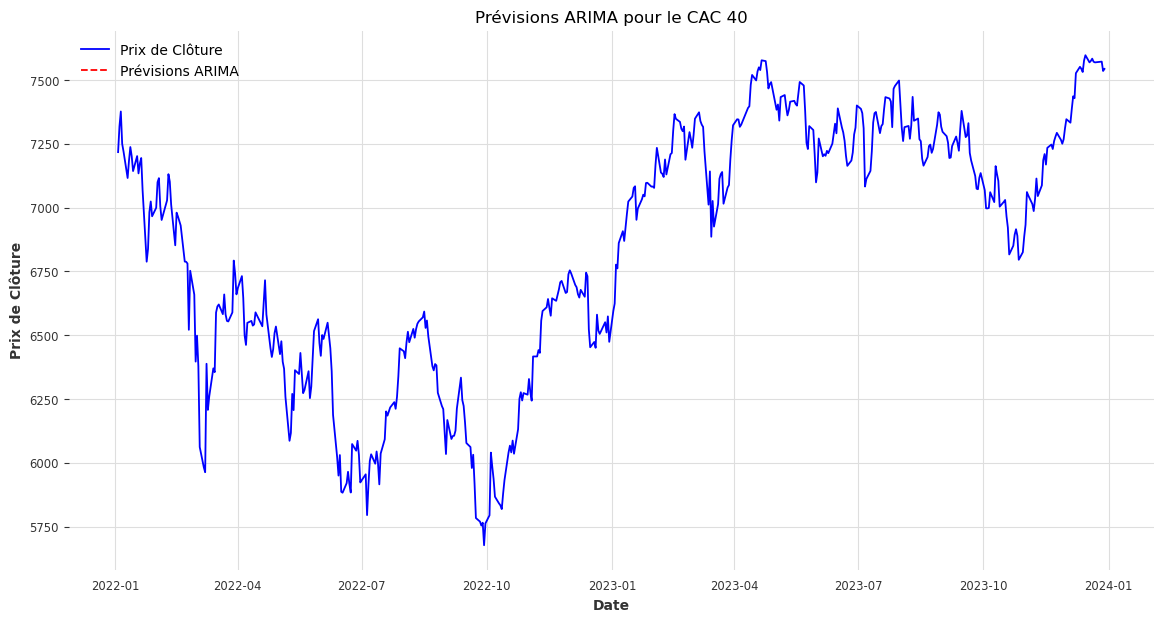

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Télécharger les données du CAC40
ticker = '^FCHI'
data = yf.download(ticker, start='2022-01-01', end='2024-01-01')

# Utiliser la colonne 'Adj Close'
ts = data['Adj Close']

# Vérifier et nettoyer les données
print("Valeurs manquantes avant nettoyage:", ts.isnull().sum())
ts = ts.dropna()
print("Valeurs manquantes après nettoyage:", ts.isnull().sum())

# Ajuster le modèle ARIMA
try:
    model = ARIMA(ts, order=(3, 1, 0))  # Essayez (p, d, q) comme (5, 1, 0)
    model_fit = model.fit()
    print(model_fit.summary())
except Exception as e:
    print(f"Erreur lors de l'ajustement du modèle ARIMA: {e}")

# Prédictions
forecast_steps = 30
try:
    forecast = model_fit.forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(days=1), periods=forecast_steps, freq='D')
    forecast_series = pd.Series(forecast, index=forecast_index)
except Exception as e:
    print(f"Erreur lors de la génération des prévisions: {e}")

# Vérifier les prévisions
print("Prévisions:")
print(forecast_series)

# Tracer les résultats
plt.figure(figsize=(14, 7))
plt.plot(ts, label='Prix de Clôture', color='blue')
if not forecast_series.empty:
    plt.plot(forecast_series, color='red', linestyle='--', label='Prévisions ARIMA')
plt.title('Prévisions ARIMA pour le CAC 40')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.grid(True)
plt.show()


### Régression polynomiale pour tenter de capturer uen éventuelle tendance non linéaire (à priori non évidente)

Erreur Quadratique Moyenne : 295.4936823326459
Coefficient de Détermination (R^2) : 0.7824503430762124


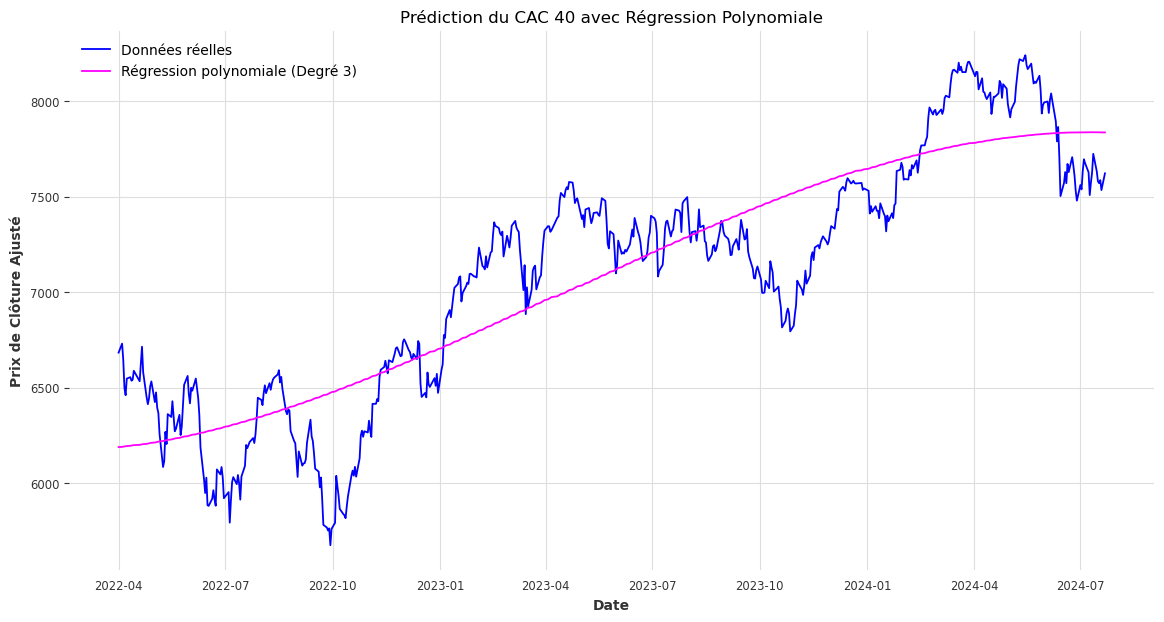

In [22]:
from sklearn.metrics import mean_squared_error, r2_score 

# On transforme l'index des jours en nombres entier pour pouvoir régresser les ordonnées sur les abcsisses

X = np.arange(len(cac40['Adj Close'])).reshape(-1,1)
y = cac40['Adj Close']

degre_polynome = 3
polynome_caracteristiques = PolynomialFeatures(degree=degre_polynome) 
X_polynome = polynome_caracteristiques.fit_transform(X)

modele = LinearRegression()
modele.fit(X_polynome, y)
y_polynome_prediction = modele.predict(X_polynome)


erreur_quadratique_moyenne = np.sqrt(mean_squared_error(y, y_polynome_prediction))
r2 = r2_score(y, y_polynome_prediction)
print(f"Erreur Quadratique Moyenne : {erreur_quadratique_moyenne}")
print(f"Coefficient de Détermination (R^2) : {r2}")


plt.figure(figsize=(14, 7))
plt.plot(cac40.index, y, label='Données réelles', color='blue')
plt.plot(cac40.index, y_polynome_prediction, color='magenta', label='Régression polynomiale (Degré 3)')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture Ajusté')
plt.title('Prédiction du CAC 40 avec Régression Polynomiale')
plt.legend()

### Automatiser le processus pour trouver le meilleur degré du polynome et mettre une explication du pourquoi on transforme d'abord les X puis on fait une régression linéaire, penser à revoir le facteur exponentiel et son calcul 